In [6]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Union, Dict, Any

In [7]:
class XGBTree:
    def __init__(self, max_depth: int, reg_lambda: float, gamma: float, tree_type: str = "regressor") -> None:
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.tree_type = tree_type
        self.root_node: Optional[Dict[str, Any]] = None
        self.features: Optional[np.ndarray] = None
        self.target_residual: Optional[np.ndarray] = None
        self.previous_predictions: Optional[np.ndarray] = None

    def calculate_node_split(self, indices: np.ndarray) -> Optional[Dict[str, Any]]:
        lambda_reg, num_features = self.reg_lambda, self.features.shape[1]  # Dòng số 1 trong thuật toán
        
        sum_gradient, sum_hessian = (
            self.target_residual[indices].sum(),  # Biểu thức số (13) và (22), dòng số 4 trong thuật toán
            (self.previous_predictions[indices] * (1 - self.previous_predictions[indices])).sum()  # Biểu thức số (26), dòng số 5 trong thuật toán
            if self.tree_type == "binary_classifier"
            else indices.shape[0],  # Biểu thức số (15), dòng số 5 trong thuật toán
        )
        
        # Dòng số 14 trong thuật toán
        best_score, maximum_gain, best_feature_index, best_split_point = None, None, None, None
        ### BEGIN SOLUTION
        maximum_gain = 0
        ### END SOLUTION

        # Dòng số 6 trong thuật toán
        for feature_index in range(num_features):
            # Dòng số 7 và 8 trong thuật toán
            gradient_left, hessian_left = None, None
            ### BEGIN SOLUTION
            gradient_left = 0
            hessian_left = 0
            ### END SOLUTION
            
            feature_values, unique_values = self.features[indices, feature_index], np.unique(self.features[indices, feature_index])
            split_candidates = [(unique_values[i - 1] + unique_values[i]) / 2 for i in range(1, len(unique_values))]
            
            # Dòng số 9 trong thuật toán
            for split in split_candidates:
                left_indices, right_indices = indices[feature_values <= split], indices[feature_values > split]

                # Biểu thức số (13) và (22), dòng số 10 trong thuật toán
                # Biểu thức số (26), dòng số 11 trong thuật toán
                # Biểu thức số (15), dòng số 11 trong thuật toán
                gradient_left, hessian_left = None, None
                ### BEGIN SOLUTION
                if self.tree_type == "binary_classifier":
                    preds_left = self.previous_predictions[left_indices]
                    gradient_left = -np.sum(self.target_residual[left_indices])
                    hessian_left = np.sum(preds_left * (1 - preds_left))
                else:
                    gradient_left = -np.sum(self.target_residual[left_indices])
                    hessian_left = left_indices.shape[0]
                ### END SOLUTION
                
                # Dòng số 12 và 13 trong thuật toán
                gradient_right, hessian_right = None, None
                ### BEGIN SOLUTION
                gradient_right = sum_gradient - gradient_left
                hessian_right = sum_hessian - hessian_left

                ### END SOLUTION
                
                # Dòng số 14 trong thuật toán
                gain = None
                ### BEGIN SOLUTION
                gain = (
                    (gradient_left ** 2) / (hessian_left + self.reg_lambda)
                    + (gradient_right ** 2) / (hessian_right + self.reg_lambda)
                    - (sum_gradient ** 2) / (sum_hessian + self.reg_lambda)
                )
                ### END SOLUTION

                # Dòng số 15 trong thuật toán
                if gain > maximum_gain:
                    maximum_gain, best_feature_index, best_split_point, _ = gain, feature_index, split, split

        return (
            {
                "feature_index": best_feature_index,
                "split_point": best_split_point,
                "left_indices": indices[self.features[indices, best_feature_index] <= best_split_point],
                "right_indices": indices[self.features[indices, best_feature_index] > best_split_point],
            }
            if maximum_gain >= self.gamma
            else None
        )

    def split_node(self, node: Dict[str, Any], depth: int) -> None:
        if depth < self.max_depth and isinstance(node, dict):
            for side in ["left_indices", "right_indices"]:
                child_node = self.calculate_node_split(node[side])
                if child_node:
                    node[side] = child_node
                    self.split_node(node[side], depth + 1)

    def calculate_output_value(self, indices: np.ndarray) -> float:
        lambda_reg, sum_hessian = (
            self.target_residual[indices],
            (self.previous_predictions[indices] * (1 - self.previous_predictions[indices])).sum()
            if self.tree_type == "binary_classifier"
            else indices.shape[0],
        )
        return self.target_residual[indices].sum() / (sum_hessian + self.reg_lambda)

    def calculate_leaf_values(self, node: Dict[str, Any]) -> None:
        if isinstance(node, dict):
            for side in ["left_indices", "right_indices"]:
                if isinstance(node[side], dict):
                    self.calculate_leaf_values(node[side])
                else:
                    node[side] = self.calculate_output_value(node[side])

    def fit(self, features: np.ndarray, target: np.ndarray, initial_predictions: Union[np.ndarray, float]) -> Optional[Dict[str, Any]]:
        self.features, self.target_residual = features, target
        self.previous_predictions = (
            initial_predictions if isinstance(initial_predictions, np.ndarray)
            else np.full(features.shape[0], initial_predictions)
        )
        root = self.calculate_node_split(np.arange(features.shape[0]))
        if root:
            self.split_node(root, depth=1)
            self.root_node = root
            self.calculate_leaf_values(self.root_node)
        return self.root_node

    def predict_single_instance(self, node: Union[Dict[str, Any], float], feature_instance: np.ndarray) -> float:
        while isinstance(node, dict):
            node = node["left_indices"] if feature_instance[node["feature_index"]] <= node["split_point"] else node["right_indices"]
        return node

    def predict(self, features_test: np.ndarray) -> np.ndarray:
        return (
            np.array([self.predict_single_instance(self.root_node, feature_instance) for feature_instance in features_test])
            if isinstance(self.root_node, dict)
            else self.previous_predictions * np.ones(features_test.shape[0])
        )

In [8]:
class XGBModel:
    def __init__(
        self,
        n_estimators: int = 10,
        max_depth: int = 3,
        eta: float = 0.3,
        gamma: float = 0.0,
        reg_lambda: float = 0.0,
        initial_score: float = 0.5,
        tree_type: str = "regressor",
    ) -> None:
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.eta = eta
        self.gamma = gamma
        self.reg_lambda = reg_lambda
        self.initial_score = initial_score
        self.tree_type = tree_type
        self.trees: list[XGBTree] = []
        self.loss_history: list[float] = []

    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        ### BEGIN SOLUTION
        return 1 / (1 + np.exp(-x))
        ### END SOLUTION

    def fit(self, features: np.ndarray, target: np.ndarray) -> None:
        if self.tree_type == "binary_classifier":
            cumulative_predictions = np.log(self.initial_score / (1 - self.initial_score))
            cumulative_predictions = np.repeat(cumulative_predictions, features.shape[0])
            loss_function = lambda target, predicted: (
                -(target * np.log(predicted + 1e-8)) + (1 - target) * np.log(1 - predicted + 1e-8)
            ).sum()
        else:
            cumulative_predictions = np.full(features.shape[0], self.initial_score)
            loss_function = lambda target, predictions: ((target - predictions) ** 2).sum()

        predictions = self.sigmoid(cumulative_predictions) if self.tree_type == "binary_classifier" else cumulative_predictions

        for _ in range(self.n_estimators):
            residual = target - predictions
            tree = XGBTree(
                max_depth=self.max_depth,
                reg_lambda=self.reg_lambda,
                gamma=self.gamma,
                tree_type=self.tree_type,
            )
            tree.fit(
                features,
                residual,
                predictions if self.tree_type == "binary_classifier" else residual.mean(),
            )
            update = tree.predict(features)
            cumulative_predictions += self.eta * update
            predictions = self.sigmoid(cumulative_predictions) if self.tree_type == "binary_classifier" else cumulative_predictions

            self.trees.append(tree)
            self.loss_history.append(loss_function(target, predictions))

    def predict(self, features_test: np.ndarray, probability: bool = False) -> np.ndarray:
        cumulative_predictions = np.zeros(shape=(features_test.shape[0],)) + self.initial_score

        for tree in self.trees:
            cumulative_predictions += self.eta * tree.predict(features_test)

        if self.tree_type == "binary_classifier":
            probabilities = self.sigmoid(cumulative_predictions)
            return probabilities if probability else (probabilities > 0.5).astype("uint8")
            
        return cumulative_predictions

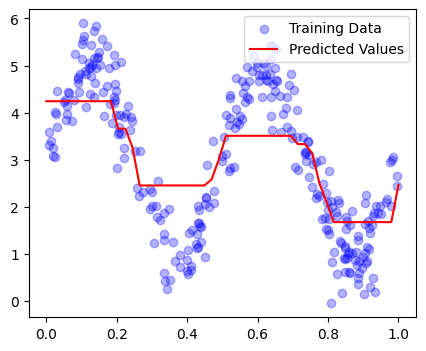

In [9]:
### BEGIN PUBLIC TESTS
import matplotlib.pyplot as plt

X = np.random.rand(300).reshape(-1, 1)
y = 2.0 * np.sin(4.0 * np.pi * X).flatten() + np.random.normal(0.0, 0.5, 300) + 3.0

model = XGBModel(
    n_estimators=20,
    max_depth=3,
    eta=0.3, 
    gamma=0.01, 
    reg_lambda=1, 
    initial_score=y.mean(),
    tree_type='regressor'
)

model.fit(X, y)

X_test = np.linspace(0, 1, 50).reshape(-1, 1)
y_pred = model.predict(X_test)

plt.figure(figsize=(5, 4))
plt.scatter(X, y, c='b', alpha=0.3, label='Training Data')
plt.plot(X_test, y_pred, c='r', label='Predicted Values')
plt.legend()
plt.show()
### END PUBLIC TESTS

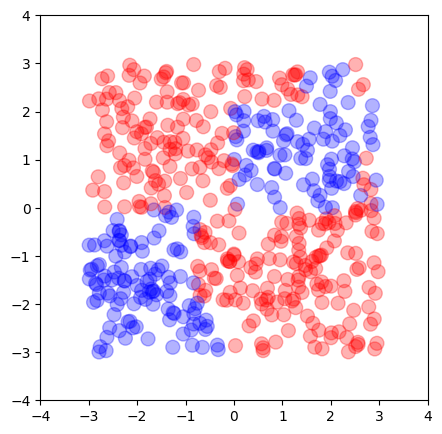

In [10]:
### BEGIN PUBLIC TESTS
X = np.random.randn(300, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

model = XGBModel(
    n_estimators=20,
    max_depth=3,
    eta=0.3,
    gamma=0.01,
    reg_lambda=1,
    initial_score=y.mean(),
    tree_type='binary_classifier'
)

model.fit(X, y)

X_test = np.random.uniform(-3, 3, (500, 2))
y_pred = model.predict(X_test)

plt.figure(figsize=(5,5))
color = ['r' if a == 1 else 'b' for a in y_pred]
plt.scatter(X_test[:, 0], X_test[:, 1], s=100, c=color, alpha=0.3)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()
### END PUBLIC TESTS